In [11]:
# !apt-get update
# !apt-get install -y librdkafka-dev

In [12]:
# !git clone https://gitlab.com/nsf-noirlab/csdc/antares/client.git

In [16]:
# %cd client
# !pip install -e .

**restart the session then:**

In [17]:
# %cd /content

In [1]:
import antares_client
print("ANTARES client imported successfully!")

ANTARES client imported successfully!


In [2]:
!pip install weightedstats


Defaulting to user installation because normal site-packages is not writeable


In [3]:
def mag_to_flux(mag, F0=1.0):
    """
    Convert magnitude to flux.

    Parameters:
    - mag : magnitude (float or array)
    - F0 : reference flux (zeropoint), default=1.0 for relative flux

    Returns:
    - flux : flux corresponding to the magnitude
    """
    flux = F0 * 10**(-0.4 * mag)
    flux = flux/np.min(flux)
    return flux

def magerr_to_fluxerr(mag, mag_err, F0=1.0):
    """
    Convert magnitude uncertainty to flux uncertainty.

    Parameters:
    - mag : magnitude value or array
    - mag_err : magnitude uncertainty value or array
    - F0 : zeropoint flux (default=1.0 for relative flux)

    Returns:
    - flux_err : flux uncertainty
    """
    flux = mag_to_flux(mag, F0)
    flux_err = 0.4 * np.log(10) * flux * mag_err
    return flux_err


# Define a Paczyński microlensing model
def paczynski(t, t0, u0, tE, F_s):
    """
    Paczyński microlensing light curve model
    t0 : peak time
    u0 : impact parameter
    tE : Einstein crossing time
    F_s : source flux
    F_b : blended flux
    """
    u = np.sqrt(u0**2 + ((t - t0) / tE) ** 2)
    A = (u**2 + 2) / (u * np.sqrt(u**2 + 4))
    return F_s * (A) + (1-F_s)




def fit_paczynski(times, mags, flxs, flx_errs):
    """
    Fit the Paczyński microlensing model to flux data.
    Returns best-fit parameters and chi-squared value.
    """
    if len(times) < 4:
        return None, None  # Not enough data



    if len(times) < 4:
        return None, None

    # initial guesses
    t0_guess = times[np.argmin(flxs)]
    u0_guess = 1.0 / (np.max(flxs))

    tE_guess = 20.0
    F0_guess = 0.5


    initial_guess = [t0_guess, u0_guess, tE_guess, F0_guess]

    bounds = (
                        [times.min() - 50, 0, 1.0, 0.0],
                        [times.max() + 50, np.inf, 500.0, 1]
                    )


    try:
        popt, _ = curve_fit(
            paczynski,
            times, flxs,
            p0=initial_guess,
            sigma=flx_errs,
            bounds=bounds,

            maxfev=5000
        )
        chi2 = np.sum(((flxs - paczynski(times, *popt)) / flx_errs) ** 2) / len(times)
        return popt, chi2
    except Exception as e:
        print(f"  Paczynski fitting error: {e}")
        return None, None



def fit_Cheby(t, y, degree=50):
    n =degree

    y_values = y
    mjd_t = t

    if n <11:
        print('Degree must be more than 10.')
        sys.exit()

    # Remove duplicate time values
    df = pd.DataFrame({'t': t, 'y': y})
    df = df.groupby('t').mean().reset_index()  # average over duplicate times
    mjd_t = df['t'].values
    y_values = df['y'].values


    xmin = min(mjd_t)
    xmax = max(mjd_t)
    bma = 0.5 * (xmax - xmin)
    bpa = 0.5 * (xmax + xmin)
    interpoll = interp1d(mjd_t, y_values, kind='cubic')
    f = [interpoll(math.cos(math.pi * (k + 0.5) / n) * bma + bpa) for k in range(n)]
    fac = 2.0 / n
    cheby_coefficients = [fac * sum([f[k] * math.cos(math.pi * j * (k + 0.5) / n) for k in range(n)]) for j in range(n)]


    Cheby_all = {}
    Cheby_func = []

    for t_i in np.sort(mjd_t):

        y = (2.0 * t_i - xmin - xmax) * (1.0 / (xmax - xmin))
        y2 = 2.0 * y
        (d, dd) = (cheby_coefficients[-1], 0)             # Special case first step for efficiency

        for cj in cheby_coefficients[-2:0:-1]:            # Clenshaw's recurrence
            (d, dd) = (y2 * d - dd + cj, d)
        Cheby_func.append(y * d - dd + 0.5 * cheby_coefficients[0])

    Cheby_all['y_fitted'] = np.asarray(Cheby_func)


    Cheby_all['Cheby_a0'] = (cheby_coefficients[0])/(cheby_coefficients[0])
    Cheby_all['Cheby_a2'] = (cheby_coefficients[2])/(cheby_coefficients[0])
    Cheby_all['Cheby_a4'] = (cheby_coefficients[4])/(cheby_coefficients[0])
    Cheby_all['Cheby_a6'] = (cheby_coefficients[6])/(cheby_coefficients[0])
    Cheby_all['Cheby_a8'] = (cheby_coefficients[8])/(cheby_coefficients[0])
    Cheby_all['Cheby_a10'] = (cheby_coefficients[10])/(cheby_coefficients[0])


    Cheby_all['Cheby_cj_sqr'] = np.sum((np.asarray(cheby_coefficients)/(cheby_coefficients[0]))**2)
    Cheby_all['log10_Cheby_cj_sqr_minus_one'] = np.log10(Cheby_all['Cheby_cj_sqr'] - 1)
    Cheby_all['pos_log10_Cheby_cj_sqr_minus_one'] = -1*np.log10(Cheby_all['Cheby_cj_sqr'] - 1)
    Cheby_all['delta_A_chebyshev_sqr'] = np.sum((y_values - Cheby_func)**2)

    return Cheby_all

In [4]:
# --- KMTNet Algorithm ---
# Authors: Atousa Kalantari, Somayeh Khakpash

"""
Implementation of the two parameter PSPL fitting procedure from Kim et al. (2018)
(https://iopscience.iop.org/article/10.3847/1538-3881/aaa47b).

This method models the microlensing single-lens light curve. The standard model involves three nonlinear parameters:
    - t0 (time of maximum magnification)
    - tE (Einstein ring crossing time)
    - u0 (minimum impact parameter)

To reduce computational cost, the algorithm operates in two regimes—high magnification and low magnification—
reducing the problem to just two nonlinear parameters: t0 and teff, where teff = tE * u0.

Model definitions:
    High Magnification regime:
        Ft_high(t, f_1, f_0, t0, t_eff) = |f_1| * Q^(-1/2) + |f_0|
        where Q = 1 + ((t - t0) / t_eff)^2

    Low Magnification regime:
        Ft_low(t, f_1, f_0, t0, t_eff) = |f_1| * [1 - (1 + Q/2)^(-2)]^(-1/2) + |f_0|
        where Q = 1 + ((t - t0) / t_eff)^2

Grid search setup:
    - t_eff ∈ [1, 100], stepped as:    t_eff_{k+1} = (1 + δ) * t_eff_k
    - For each t_eff, t0 grid:         t0_{k, l+1} = t0_{k, l} + δ * t_eff_k
    - Step size:                       δ = 1/3

For each (t0, t_eff) grid point, fitting is performed using data within the window: t0 ± Z * t_eff, with Z = 7.
Each window must contain at least 10 data points.

The best-fit parameters (t0, t_eff, f0, f1) are identified from this grid search.

Subsequently, a linear “flat” model is also fit to the data in the region t0_best ± 7 * t_eff_best to obtain chi2_flat.

We then compute the delta chi-squared metric as:
    delta_chi_squared_kmt = |chi_mlens - chi2_linearfit| / chi2_linearfit

Empirically, if delta_chi_squared_kmt > 0.9, we consider the event a microlensing candidate.


The chosen metric threshold (>0.9), window size (Z = 7) and at least 10 datapoints, step size (delta = 1/3), and teff range ([1, 100]) are based on Rubin cadence and observed days.
***These values must be checked and validated to ensure they are optimal.***
"""



import numpy as np
import pandas as pd
from scipy.optimize import minimize
import warnings
import weightedstats as ws

def run_kmtnet_fit(times, fluxes, flux_errors):

    """
    Fit a two-parameter PSPL (KMTNet-Algorithm) model to a light curve,
    using a grid search over t0 and t_eff,
    and return Delta_Chi2 along with best-fit parameters.
    """

    # Ensure inputs are numpy arrays
    times = np.asarray(times)
    fluxes = np.asarray(fluxes)
    flux_errors = np.asarray(flux_errors)

    # Filter out NaNs from input data before creating DataFrame
    valid_data_indices = ~np.isnan(times) & ~np.isnan(fluxes) & ~np.isnan(flux_errors) & (flux_errors > 0)
    times, fluxes, flux_errors = times[valid_data_indices], fluxes[valid_data_indices], flux_errors[valid_data_indices]

    if len(times) < 5: # KMTNet fit needs sufficient data points
        return None, None, None # Not enough data for KMTNet fit

    data_df = pd.DataFrame({
        'time': times,
        'flux': fluxes,
        'flux_err': flux_errors
    })

    # --- Model Definitions ---
    # Functions for high and low magnification regimes,
    # params: (t, f_1, f_0, t0, t_eff)

    def Ft_high(t, f_1, f_0, t0, t_eff):
        # High-mag analytic approximation
        Q = 1 + ((t - t0) / t_eff)**2
        return np.abs(f_1) * (Q**(-1.0 / 2)) + np.abs(f_0)

    def Ft_low(t, f_1, f_0, t0, t_eff):
         # Low-mag analytic approximation
        Q = 1 + ((t - t0) / t_eff)**2
        return np.abs(f_1) * (1 - (1 + Q / 2)**-2)**(-1.0 / 2) + np.abs(f_0)

     # --- Chi2 Functions for Minimization ---
    def chi2_high(f_params, t, flux, flux_err, t0, teff):
        # Compute chi^2 for the high-mag model (minimize over f1, f0)
        f_1, f_0 = f_params
        model = Ft_high(t, f_1, f_0, t0, teff)
        inv_sigma2 = 1.0 / (flux_err**2)
        return np.sum((flux - model)**2 * inv_sigma2)

    def chi2_low(f_params, t, flux, flux_err, t0, teff):
        # Compute chi^2 for the low-mag model
        f_1, f_0 = f_params
        model = Ft_low(t, f_1, f_0, t0, teff)
        inv_sigma2 = 1.0 / (flux_err**2)
        return np.sum((flux - model)**2 * inv_sigma2)

    # --- Grid Search: Build t0-teff grid for nonlinear fitting ---
    teff_min, teff_max = 1, 100
    teff_list, t0_tE_list = [], []
    current_teff = teff_min

    # Build teff grid (teff_{k+1} = (1 + delta) * teff_k)
    while current_teff <= teff_max:
        teff_list.append(current_teff)
        delta = 1/5 if current_teff < 1 else 1/3
        current_teff *= (1 + delta)

    # For each teff, build the grid of t0 values
    t0_min, t0_max = np.min(times), np.max(times)
    for teff in teff_list:
        t0_current = t0_min
        while t0_current <= t0_max:
            t0_tE_list.append([t0_current, teff])
            delta = 1/5 if teff < 1 else 1/3
            t0_current += delta * teff

    # If no grid was produced, exit
    if not t0_tE_list: return None, None, None


    # --- Main Grid Fit Loop ---
    param1, param2 = [], []  # Will store fit results for high and low mag regimes
    f_initial = [0.01, 0.99] # Initial guess for f_1, f_0

    for i, (t0_val, teff_val) in enumerate(t0_tE_list):
        # For each grid point, select data within the relevant window (t0 ± 7 teff)
        df_i = data_df[(data_df['time'] > (t0_val - 7 * teff_val)) & (data_df['time'] < (t0_val + 7 * teff_val))]

        if len(df_i) < 10:
            continue # Skip if not enough data in interval

        # Prepare arguments for minimize (t, flux, flux_err, t0_val, teff_val)
        args = (df_i['time'].values, df_i['flux'].values, df_i['flux_err'].values, t0_val, teff_val)

        try:
            # Fit the high-magnification model for current grid point
            result1 = minimize(chi2_high, f_initial, args=args, method='BFGS')
            # Compute chi2 for the entire dataset using best-fit parameters
            model_diff1 = data_df['flux'].values - Ft_high(data_df['time'].values, result1.x[0], result1.x[1], t0_val, teff_val)
            chi2_all1 = np.sum((model_diff1)**2 * (1.0 / (data_df['flux_err'].values**2)))


            # Fit the low-magnification model
            result2 = minimize(chi2_low, f_initial, args=args, method='BFGS')
            model_diff2 = data_df['flux'].values - Ft_low(data_df['time'].values, result2.x[0], result2.x[1], t0_val, teff_val)
            chi2_all2 = np.sum((model_diff2)**2 * (1.0 / (data_df['flux_err'].values**2)))

            # Store: [index, t0, teff, f1, f0, local_chi2, window_npts, global_chi2, npts]
            param1.append([i, t0_val, teff_val, result1.x[0], result1.x[1], result1.fun,
                            len(df_i), chi2_all1, len(data_df)])
            param2.append([i, t0_val, teff_val, result2.x[0], result2.x[1], result2.fun,
                            len(df_i), chi2_all2, len(data_df)])
        except Exception as e:
            # If optimization fails, print a warning but continue
            print(f"Warning: KMTNet minimize failed for iteration {i}: {e}")
            continue

    # If no fits were successful, exit
    if not param1 and not param2: return None, None, None

    # --- Select Best-fit Parameters ---
    # Find best fits: lowest chi2 on entire dataset for both regimes
    min_value1 = min(param1, key=lambda x: x[7])
    min_value2 = min(param2, key=lambda x: x[7])

    # Use the regime (high or low mag) with the best global chi2
    if min_value1 < min_value2:
              min_value = min_value1
              param = param1
              F_t = Ft_high
              which_regim = 'high'

    else:
              min_value = min_value2
              param = param2
              F_t = Ft_low
              which_regim = 'low'

    # Extract the precise parameters where chi2 is minimized
    for sublist in param:
        if sublist[7] == min_value[7]:
            parameter = sublist



    chi_mlens = parameter[7] # Minimum chi2 for microlensing fit
    t0 = parameter[1]
    t_eff = parameter[2]
    f1 = parameter[3]
    f0 = parameter[4]

    # --- Linear Fit for Flat Model ---
    # Fit a constant flux to the light curve in the same window
    data_df_interval = data_df[(data_df['time'] > (t0 - 7 * t_eff)) & (data_df['time'] < (t0 + 7 * t_eff))]

    if len(data_df_interval) == 0:
        # Fallback to global mean if window is empty
        mean_flux_interval = np.mean(data_df['flux'].values)
    else:
        # Ensure weights are valid (not zero or inf)
        weights = 1.0 / (data_df_interval['flux_err'].values**2)
        valid_weights_indices = ~np.isinf(weights) & ~np.isnan(weights) & (weights > 0)
        if np.sum(valid_weights_indices) > 0:
            mean_flux_interval = ws.weighted_mean(data_df_interval['flux'].values[valid_weights_indices],
                                                  weights[valid_weights_indices])
        else:
            mean_flux_interval = np.mean(data_df['flux'].values)

    # Compute chi2 for flat line fit
    chi2_linearfit = np.sum((data_df['flux'] - mean_flux_interval)**2 / (data_df['flux_err']) ** 2)


     # --- Compute Metric and Return ---
    if chi2_linearfit == 0:
        delta_chi_squared_kmt = 0
    else:
        delta_chi_squared_kmt = (abs(chi_mlens - chi2_linearfit) / chi2_linearfit)

    # Return: delta chi2, best-fit physical params
    # If delta_chi_squared_kmt > 0.9, the light curve would be a microlensing candidate.
    return delta_chi_squared_kmt, (t0, t_eff, f1, f0)





In [5]:
from KMTNET_Algorithm import run_kmtnet_fit

In [25]:
# --- Imports ---
import numpy as np
import warnings
import astropy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from scipy.stats import skew
import pandas as pd
import weightedstats as ws
from scipy.interpolate import interp1d
import math
import time


# Import the ANTARES client for data fetching
import antares_client.search as acs





class MicrolensingAnalyzer:

    def __init__(self):
        pass


    def analyze_fitting_results(self, times, mags, errors, band_label=None, locus_id=None):
      """
      Analyze Paczynski, KMTNet, and Chebyshev fits and Eta and Gamma. Plot the light curve and fits.
      Returns a dictionary with all fitting results.
      """
      times, mags, errors = np.array(times), np.array(mags), np.array(errors)

      if len(times) < 10:
          print("  Not enough data points for fitting analysis (minimum 10 required).")
          return None

      # Clean and sort data
      valid_mask = ~np.isnan(times) & ~np.isnan(mags) & ~np.isnan(errors)
      times, mags, errors = times[valid_mask], mags[valid_mask], errors[valid_mask]
      sorted_idx = np.argsort(times)
      times, mags, errors = times[sorted_idx], mags[sorted_idx], errors[sorted_idx]

      flxs = mag_to_flux(mags)
      flx_errs = magerr_to_fluxerr(mags, errors)

      valid_flux_mask = ~np.isnan(flxs) & ~np.isnan(flx_errs) & (flx_errs > 0)
      times_for_fit = times[valid_flux_mask]
      flxs = flxs[valid_flux_mask]
      flx_errs = flx_errs[valid_flux_mask]
      mags = mags[valid_flux_mask]

      if len(times_for_fit) < 4:
          print("  Not enough valid flux data points for fitting analysis.")
          return None

      fitting_results = {}

      # Plot
      plt.figure(figsize=(10, 6))
      plt.errorbar(times_for_fit, flxs, yerr=flx_errs, fmt='o', color='blue', alpha=0.6,
                  label=f'{band_label} data' if band_label else 'data')

      # --- Paczynski Fit ---

      # Start timing
      start_time = time.time()

      popt, chi2_paczynski = fit_paczynski(times_for_fit, mags, flxs, flx_errs)
      if popt is not None:
          t0, u0, tE, F0 = popt
          reduced_chi2_paczynski = chi2_paczynski / (len(times_for_fit) - 4)
          fitting_results['paczynski'] = {
              'parameters': {'t0': t0, 'u0': u0, 'tE': tE, 'F0': F0},
              'chi2': chi2_paczynski,
              'reduced_chi2': reduced_chi2_paczynski,
              'fit_successful': True
          }
          pac_fit = paczynski(times_for_fit, t0, u0, tE, F0)
          # End timing
          end_time = time.time()

          # Calculate duration
          duration = end_time - start_time
          print(f"Paczynski execution time: {duration:.4f} seconds")

          plt.plot(times_for_fit, pac_fit, color='green', lw=2, label=f'Paczynski fit ({band_label})')
      else:
          fitting_results['paczynski'] = {'fit_successful': False}
          print("  Paczynski fit failed.")

      # --- KMTNet Fit ---

      # Start timing
      start_time = time.time()
      try:
          kmt_metric, params, which_regim = run_kmtnet_fit(times_for_fit, flxs, flx_errs)
          if kmt_metric is not None:
              # kmt_metric, params = kmt_result
              t0_kmt, teff_kmt, f1_kmt, f0_kmt = params
              # reduced_chi_mlens = chi_mlens / (len(times_for_fit) - 4)
              fitting_results['kmtnet'] = {
                  'parameters': {
                      't0': t0_kmt, 'teff': teff_kmt,
                      'f1': f1_kmt, 'f0': f0_kmt
                  },
                  'chi2_microlensing': chi_mlens,
                  'chi2_linear': chi2_linearfit,
                  'reduced_chi2_microlensing': reduced_chi_mlens,
                  'delta_chi2': kmt_metric,
                  'fit_successful': True
              }
              model_kmt = F_t(times_for_fit, f1_kmt, f0_kmt, t0_kmt, teff_kmt)

              # End timing
              end_time = time.time()

              # Calculate duration
              duration = end_time - start_time
              print(f"KMTNET execution time: {duration:.4f} seconds")

              plt.plot(times_for_fit, model_kmt, color='magenta', lw=2, linestyle='--', label=f'KMTNet fit ({band_label})')
          else:
              fitting_results['kmtnet'] = {'fit_successful': False}
              print("  KMTNet fit failed.")



      except Exception as e:
          fitting_results['kmtnet'] = {'fit_successful': False}
          print(f"  KMTNet fit failed: {e}")

      # --- Chebyshev Fit ---
      try:

          cheby = fit_Cheby(times_for_fit, flxs)
          fitting_results['chebyshev'] = cheby
          # plt.plot(times_for_fit, cheby['y_fitted'], color='orange', lw=1.5, linestyle='-.', label=f'Chebyshev fit ({band_label})')
      except Exception as e:
          print(f"  Chebyshev fit failed: {e}")


      plt.xlabel('Time (MJD)')
      plt.ylabel('Flux')
      plt.title(f"{locus_id} Light Curve - {band_label}" if locus_id else "Light Curve")
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

      # Eta & Gamma
      try:
          differences = np.diff(flxs)
          sum_squared_diff = np.sum(differences ** 2) / (len(flxs) - 1)
          variance = np.var(flxs, ddof=0)
          eta_values = sum_squared_diff / variance

          mean_flux = np.mean(flxs)
          diff = flxs - mean_flux
          diff_cubed = diff ** 3
          sum_diff_cubed = np.sum(diff_cubed)
          N = len(flxs)
          gamma = sum_diff_cubed / (N * (np.sqrt(variance) ** 3))
          fitting_results['variability_stats'] = {'eta': eta_values, 'gamma': gamma}

      except Exception as e:
          print(f"Error computing statistics: {e}")

      return fitting_results

    def analyze_locus(self, locus):
        """
        Analyzes a single locus object for fitting results across different bands.
        """
        print(f'Starting fitting analysis for Locus: {locus.locus_id}')

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", astropy.table.TableReplaceWarning)
            df = locus.timeseries.to_pandas()

        required_cols = ['ant_mjd', 'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf']
        if not all(col in df.columns for col in required_cols):
            print(f"  Skipping analysis for {locus.locus_id}: Missing required ZTF columns.")
            return None

        data = df[required_cols].dropna()

        if data.empty:
            print(f"  No valid data points for analysis for {locus.locus_id}.")
            return None

        all_results = {}

        for band_id, band_name in zip([1, 2], ['g-band', 'r-band']):
            band_data = data[data['ztf_fid'] == band_id]

            if band_data.empty:
                print(f"  No {band_name} data available.")
                continue

            times = band_data['ant_mjd'].values
            mags = band_data['ztf_magpsf'].values
            errors = band_data['ztf_sigmapsf'].values

            if len(times) < 10:
                print(f"  Not enough {band_name} data points for analysis (have {len(times)}, need ≥10).")
                continue

            fitting_results = self.analyze_fitting_results(times, mags, errors, band_label=band_name, locus_id=locus.locus_id)
            all_results[band_name] = fitting_results

        return all_results






=== Processing Locus: ANT2023wuk92lk9fz76 (Class: microlensing) ===
Starting fitting analysis for Locus: ANT2023wuk92lk9fz76
Paczynski execution time: 0.0073 seconds
  KMTNet fit failed: name 'chi_mlens' is not defined


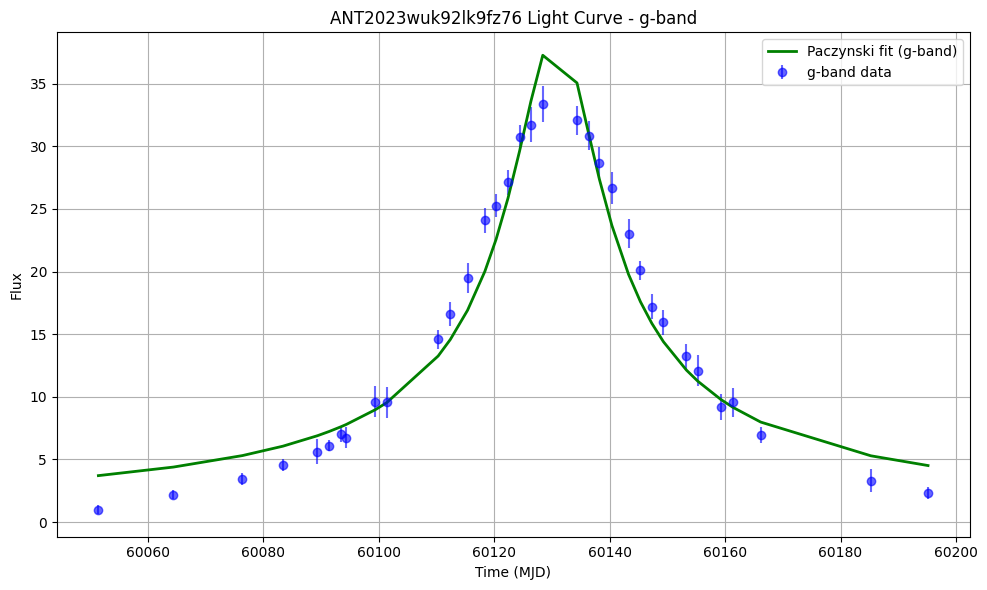

Paczynski execution time: 0.0060 seconds
  KMTNet fit failed: name 'chi_mlens' is not defined


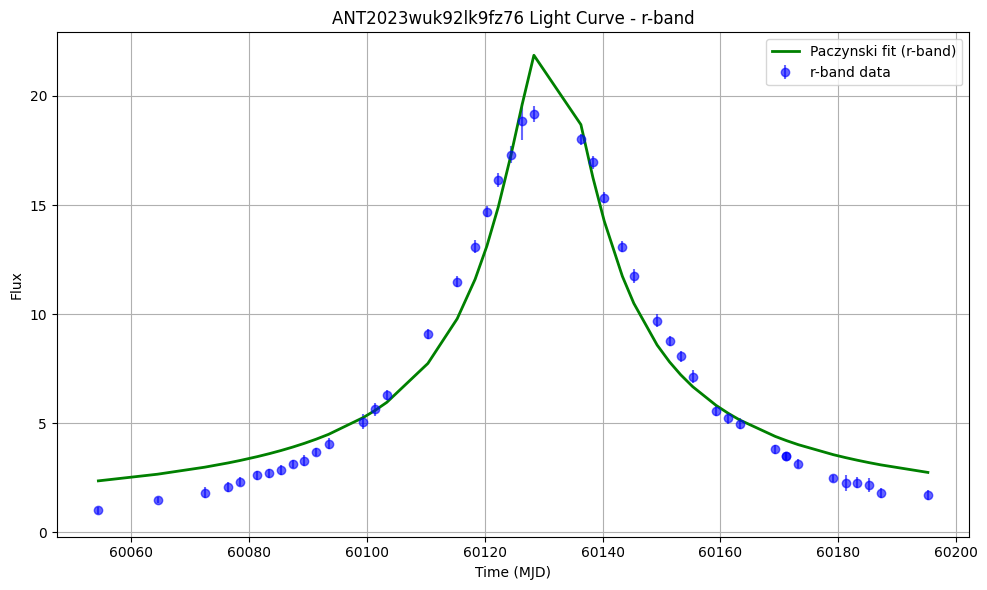


=== FINAL FITTING SUMMARY FOR ANT2023wuk92lk9fz76 ===

G-BAND Summary:
  Paczynski: Chi2=7.619, Reduced Chi2=0.254
  Variability Stats: Eta=0.0510, Gamma=0.2990
  Chebyshev Features:
    Cheby_a2 = -0.6106
    Cheby_a4 = 0.3468
    Cheby_a6 = -0.1813
    Cheby_a8 = 0.0799
    Cheby_a10 = -0.0536
    pos_log10_Cheby_cj_sqr_minus_one = 0.2092
    delta_A_chebyshev_sqr = 4.4864

R-BAND Summary:
  Paczynski: Chi2=18.559, Reduced Chi2=0.453
  Variability Stats: Eta=0.0366, Gamma=0.8754
  Chebyshev Features:
    Cheby_a2 = -0.5935
    Cheby_a4 = 0.3247
    Cheby_a6 = -0.1772
    Cheby_a8 = 0.1036
    Cheby_a10 = -0.0427
    pos_log10_Cheby_cj_sqr_minus_one = 0.2601
    delta_A_chebyshev_sqr = 0.3903

=== Processing Locus: ANT202306emoursp7gp (Class: microlensing) ===
Starting fitting analysis for Locus: ANT202306emoursp7gp
Paczynski execution time: 0.0092 seconds
  KMTNet fit failed: name 'chi_mlens' is not defined


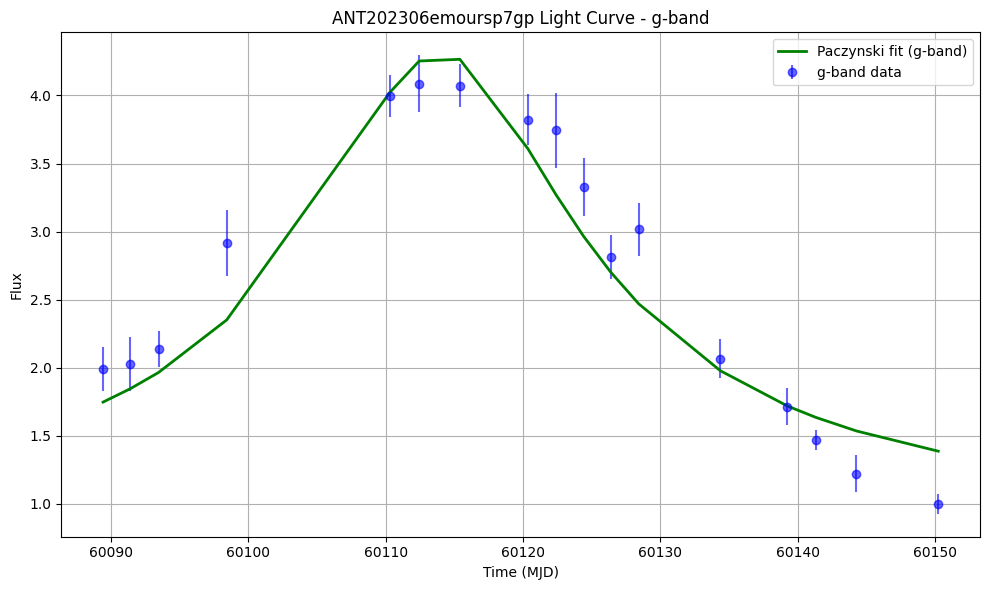

Paczynski execution time: 0.0075 seconds
  KMTNet fit failed: name 'chi_mlens' is not defined


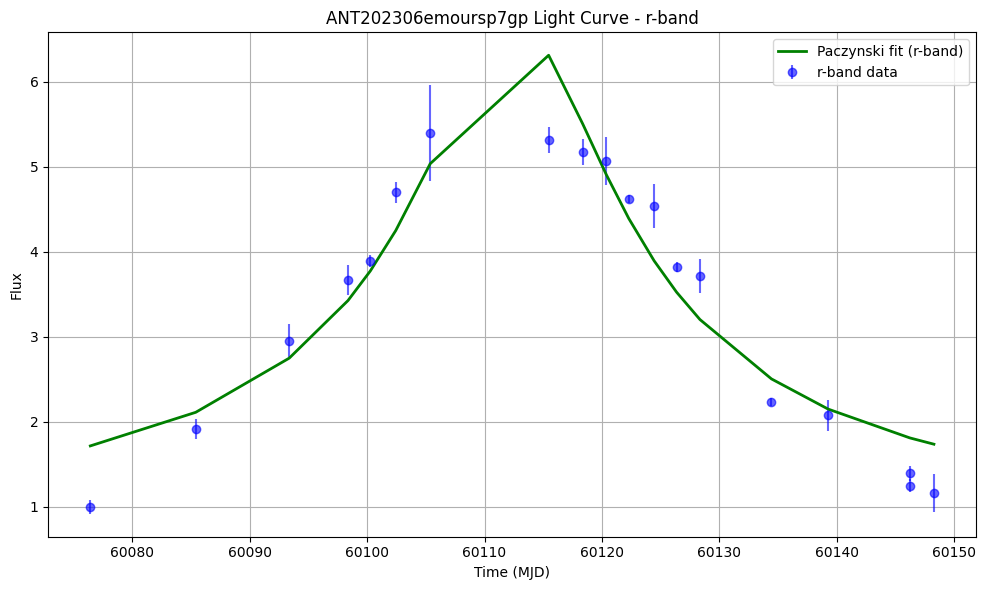


=== FINAL FITTING SUMMARY FOR ANT202306emoursp7gp ===

G-BAND Summary:
  Paczynski: Chi2=3.996, Reduced Chi2=0.307
  Variability Stats: Eta=0.2135, Gamma=-0.0176
  Chebyshev Features:
    Cheby_a2 = -0.2445
    Cheby_a4 = 0.0525
    Cheby_a6 = 0.0052
    Cheby_a8 = 0.0028
    Cheby_a10 = -0.0034
    pos_log10_Cheby_cj_sqr_minus_one = 1.0370
    delta_A_chebyshev_sqr = 0.0002

R-BAND Summary:
  Paczynski: Chi2=16.651, Reduced Chi2=1.110
  Variability Stats: Eta=0.1785, Gamma=-0.2195
  Chebyshev Features:
    Cheby_a2 = -0.3880
    Cheby_a4 = 0.1882
    Cheby_a6 = 0.0418
    Cheby_a8 = 0.0451
    Cheby_a10 = -0.0352
    pos_log10_Cheby_cj_sqr_minus_one = 0.6454
    delta_A_chebyshev_sqr = 0.0050

=== Processing Locus: ANT2020b23ci (Class: non-microlensing) ===
Starting fitting analysis for Locus: ANT2020b23ci
Paczynski execution time: 0.0118 seconds
  KMTNet fit failed: name 'chi_mlens' is not defined


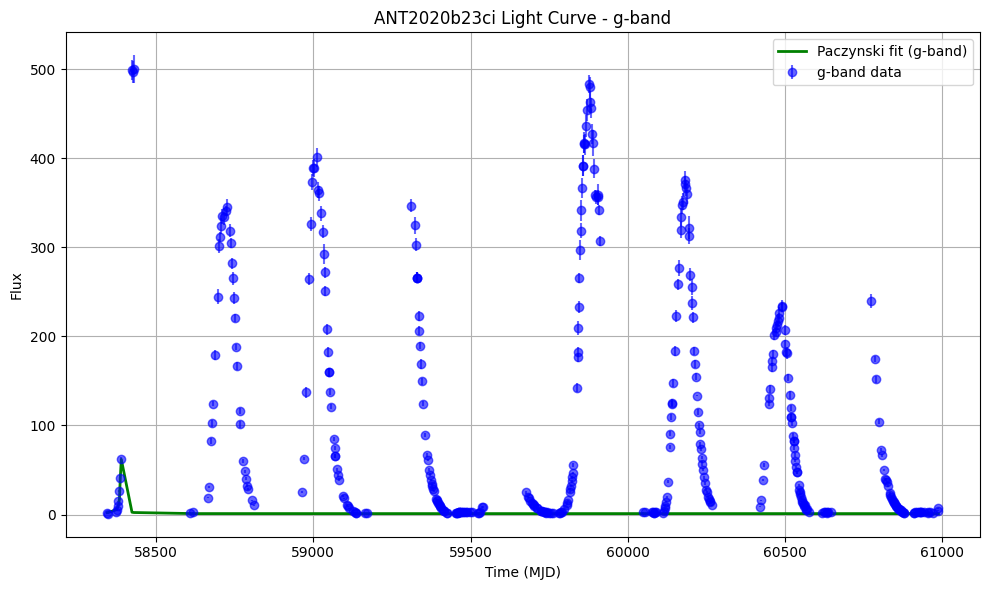

Paczynski execution time: 0.0098 seconds
  KMTNet fit failed: name 'chi_mlens' is not defined


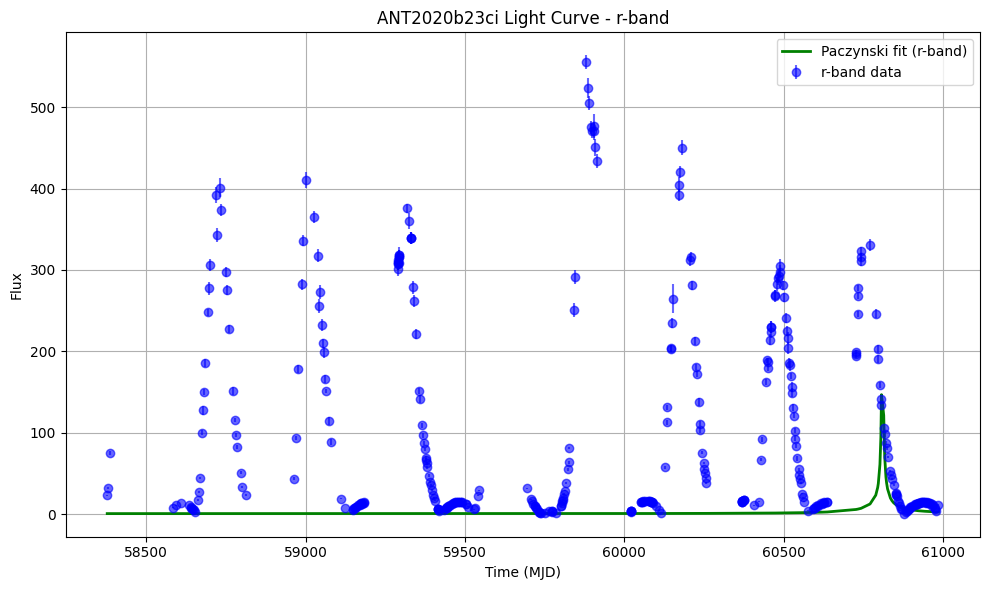


=== FINAL FITTING SUMMARY FOR ANT2020b23ci ===

G-BAND Summary:
  Paczynski: Chi2=850.572, Reduced Chi2=2.305
  Variability Stats: Eta=0.1228, Gamma=1.1069
  Chebyshev Features:
    Cheby_a2 = 0.0201
    Cheby_a4 = -0.1378
    Cheby_a6 = -0.2964
    Cheby_a8 = -0.3197
    Cheby_a10 = 0.0309
    pos_log10_Cheby_cj_sqr_minus_one = -0.1078
    delta_A_chebyshev_sqr = 1495690.6622

R-BAND Summary:
  Paczynski: Chi2=1071.307, Reduced Chi2=2.992
  Variability Stats: Eta=0.1014, Gamma=1.2479
  Chebyshev Features:
    Cheby_a2 = -0.0463
    Cheby_a4 = -0.6915
    Cheby_a6 = -0.2195
    Cheby_a8 = 0.2609
    Cheby_a10 = 0.7640
    pos_log10_Cheby_cj_sqr_minus_one = -0.9848
    delta_A_chebyshev_sqr = 31304107839.7863

=== Processing Locus: ANT2020ae7egfi (Class: microlensing) ===
Starting fitting analysis for Locus: ANT2020ae7egfi
  Not enough g-band data points for analysis (have 1, need ≥10).
  Not enough r-band data points for analysis (have 9, need ≥10).
  No fitting results available for 

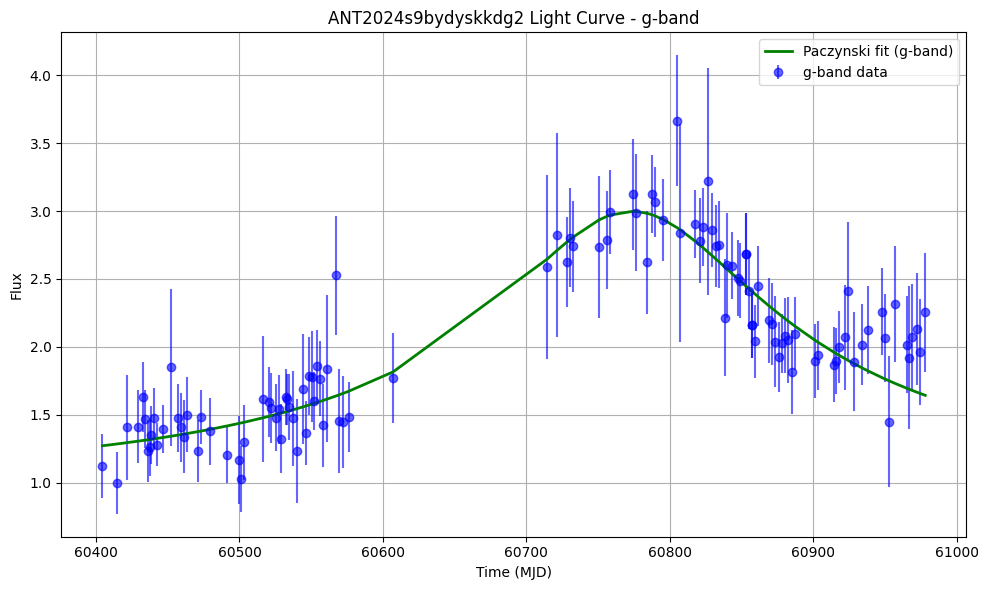

Paczynski execution time: 0.0113 seconds
  KMTNet fit failed: name 'chi_mlens' is not defined


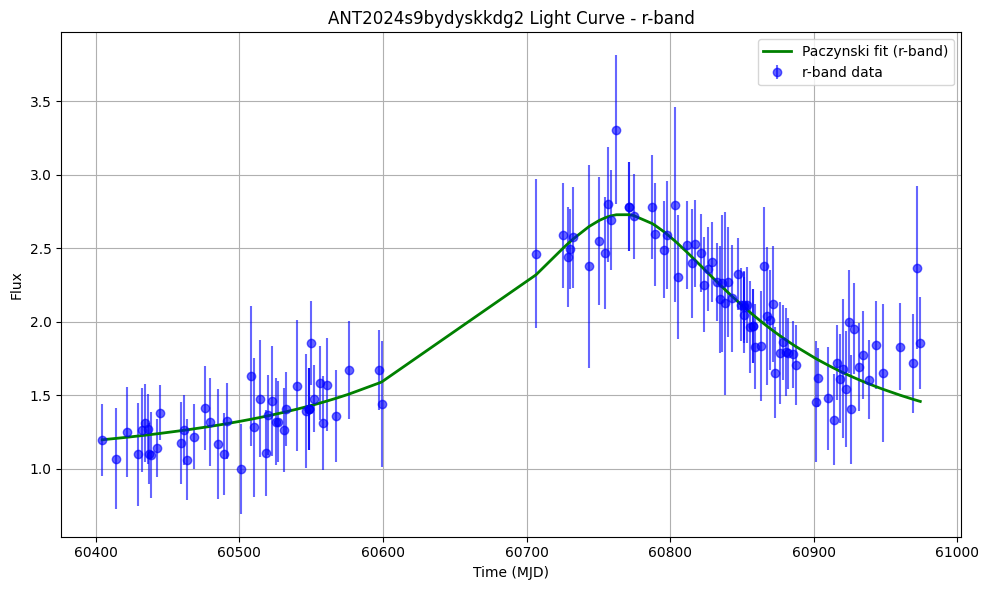


=== FINAL FITTING SUMMARY FOR ANT2024s9bydyskkdg2 ===

G-BAND Summary:
  Paczynski: Chi2=0.485, Reduced Chi2=0.004
  Variability Stats: Eta=0.2486, Gamma=0.4196
  Chebyshev Features:
    Cheby_a2 = -0.1021
    Cheby_a4 = 0.0037
    Cheby_a6 = 0.0135
    Cheby_a8 = -0.0448
    Cheby_a10 = 0.0318
    pos_log10_Cheby_cj_sqr_minus_one = 1.2449
    delta_A_chebyshev_sqr = 6.8298

R-BAND Summary:
  Paczynski: Chi2=0.254, Reduced Chi2=0.002
  Variability Stats: Eta=0.2360, Gamma=0.3936
  Chebyshev Features:
    Cheby_a2 = -0.0356
    Cheby_a4 = -0.0127
    Cheby_a6 = 0.0707
    Cheby_a8 = -0.0600
    Cheby_a10 = 0.0276
    pos_log10_Cheby_cj_sqr_minus_one = 0.9550
    delta_A_chebyshev_sqr = 3.7247

=== Processing Locus: ANT2020b2ppw (Class: non-microlensing) ===
Starting fitting analysis for Locus: ANT2020b2ppw
Paczynski execution time: 0.0326 seconds
  KMTNet fit failed: name 'chi_mlens' is not defined


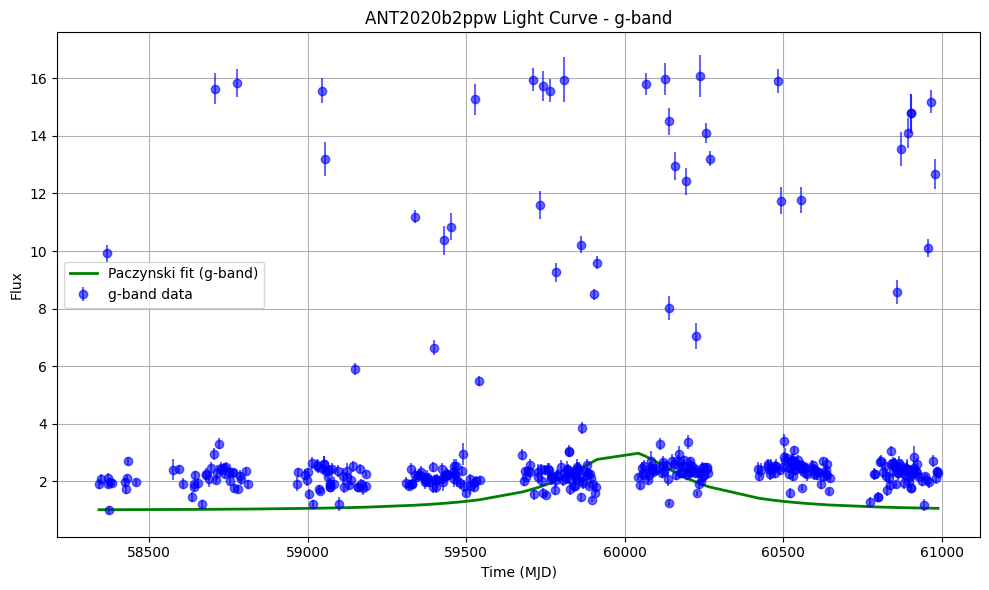

Paczynski execution time: 0.0157 seconds
  KMTNet fit failed: name 'chi_mlens' is not defined


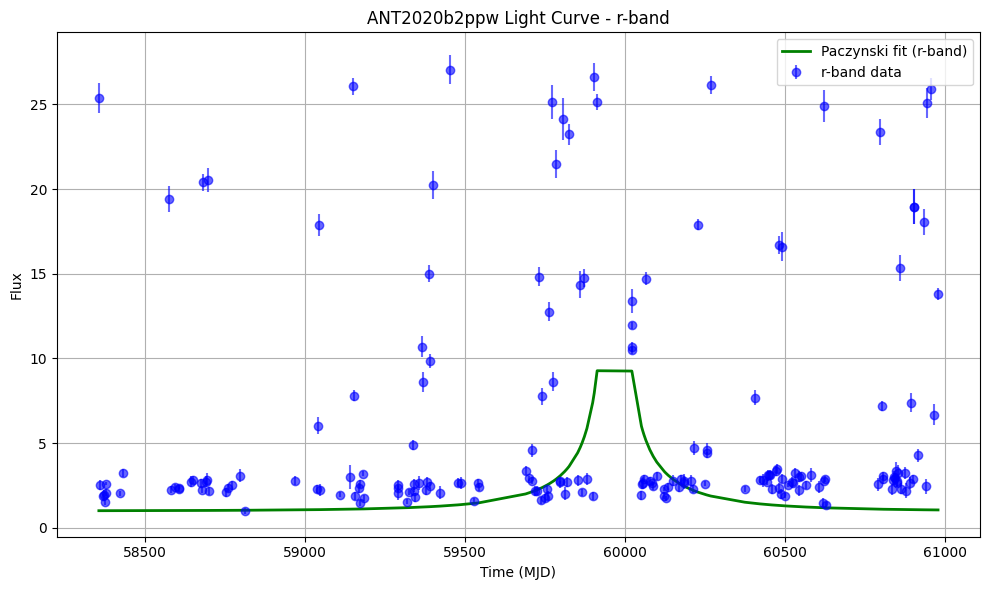


=== FINAL FITTING SUMMARY FOR ANT2020b2ppw ===

G-BAND Summary:
  Paczynski: Chi2=111.842, Reduced Chi2=0.276
  Variability Stats: Eta=2.1279, Gamma=2.9434
  Chebyshev Features:
    Cheby_a2 = -0.2705
    Cheby_a4 = 0.0094
    Cheby_a6 = 0.2782
    Cheby_a8 = -0.1786
    Cheby_a10 = -0.0413
    pos_log10_Cheby_cj_sqr_minus_one = -0.4440
    delta_A_chebyshev_sqr = 19459.3694

R-BAND Summary:
  Paczynski: Chi2=194.110, Reduced Chi2=1.049
  Variability Stats: Eta=1.8576, Gamma=1.7544
  Chebyshev Features:
    Cheby_a2 = -0.7362
    Cheby_a4 = 0.4951
    Cheby_a6 = -0.0257
    Cheby_a8 = -0.4847
    Cheby_a10 = 0.7796
    pos_log10_Cheby_cj_sqr_minus_one = -1.3403
    delta_A_chebyshev_sqr = 53798639.1173

=== Processing Locus: ANT2019klw2u (Class: non-microlensing) ===
Starting fitting analysis for Locus: ANT2019klw2u
Paczynski execution time: 0.0058 seconds
  KMTNet fit failed: name 'chi_mlens' is not defined


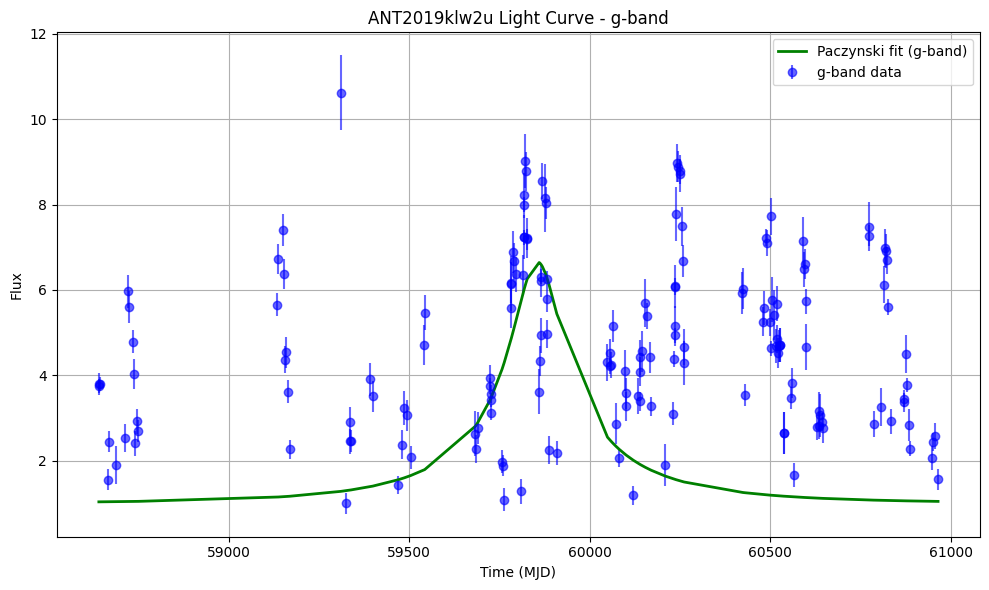

Paczynski execution time: 0.0044 seconds
  KMTNet fit failed: name 'chi_mlens' is not defined


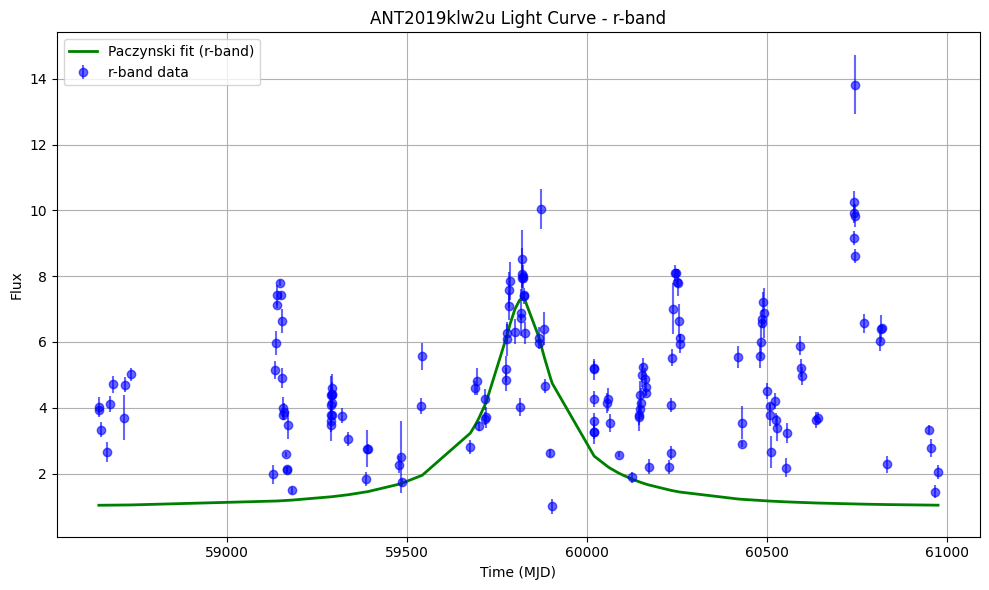


=== FINAL FITTING SUMMARY FOR ANT2019klw2u ===

G-BAND Summary:
  Paczynski: Chi2=96.475, Reduced Chi2=0.592
  Variability Stats: Eta=0.7915, Gamma=0.4150
  Chebyshev Features:
    Cheby_a2 = -2.4424
    Cheby_a4 = 5.7797
    Cheby_a6 = 2.2033
    Cheby_a8 = -5.3548
    Cheby_a10 = 0.1413
    pos_log10_Cheby_cj_sqr_minus_one = -2.4048
    delta_A_chebyshev_sqr = 2083.6493

R-BAND Summary:
  Paczynski: Chi2=357.069, Reduced Chi2=2.429
  Variability Stats: Eta=0.4665, Gamma=0.8425
  Chebyshev Features:
    Cheby_a2 = -0.0337
    Cheby_a4 = -0.7557
    Cheby_a6 = -0.0800
    Cheby_a8 = 0.2662
    Cheby_a10 = 0.4528
    pos_log10_Cheby_cj_sqr_minus_one = -0.7511
    delta_A_chebyshev_sqr = 78123434.9492

=== Processing Locus: ANT2020vrqwg (Class: non-microlensing) ===
Starting fitting analysis for Locus: ANT2020vrqwg
Paczynski execution time: 0.0074 seconds
  KMTNet fit failed: name 'chi_mlens' is not defined


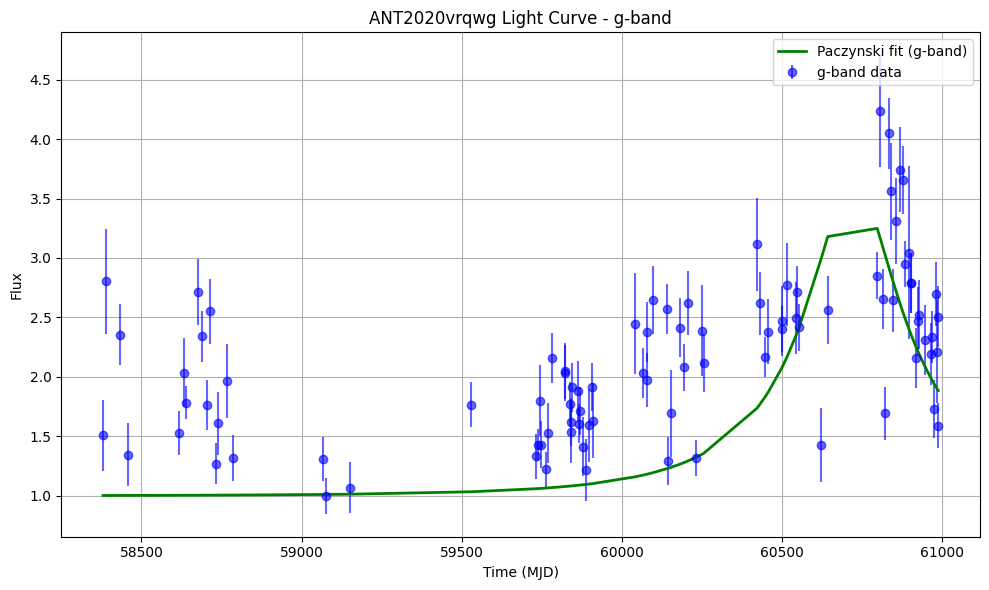

Paczynski execution time: 0.0139 seconds
  KMTNet fit failed: name 'chi_mlens' is not defined


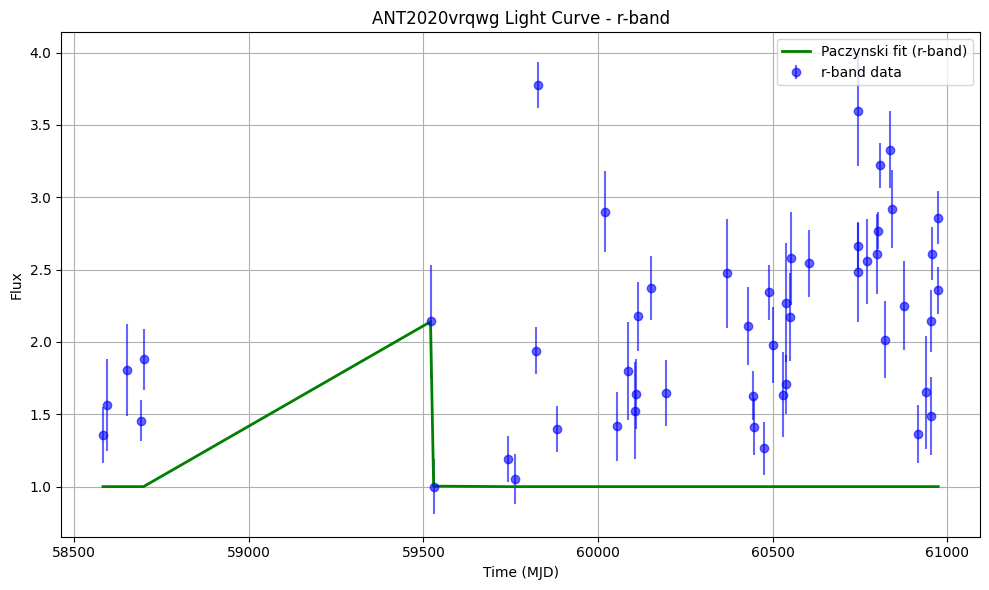


=== FINAL FITTING SUMMARY FOR ANT2020vrqwg ===

G-BAND Summary:
  Paczynski: Chi2=9.283, Reduced Chi2=0.107
  Variability Stats: Eta=0.9298, Gamma=0.6739
  Chebyshev Features:
    Cheby_a2 = 0.0210
    Cheby_a4 = 0.1019
    Cheby_a6 = 0.1262
    Cheby_a8 = -0.0572
    Cheby_a10 = -0.0458
    pos_log10_Cheby_cj_sqr_minus_one = 0.6546
    delta_A_chebyshev_sqr = 58.3345

R-BAND Summary:
  Paczynski: Chi2=35.752, Reduced Chi2=0.761
  Variability Stats: Eta=1.4457, Gamma=0.5059
  Chebyshev Features:
    Cheby_a2 = 0.1654
    Cheby_a4 = -0.8884
    Cheby_a6 = -0.4493
    Cheby_a8 = 0.6667
    Cheby_a10 = 0.6637
    pos_log10_Cheby_cj_sqr_minus_one = -0.8861
    delta_A_chebyshev_sqr = 4086285.0401

=== Processing Locus: ANT2020ar224 (Class: non-microlensing) ===
Starting fitting analysis for Locus: ANT2020ar224
Paczynski execution time: 0.0130 seconds


In [ ]:
# with 10 datapoints limit, z=8, teff= (1,100)

import pandas as pd

# Define ANTARES targets
antares_targets = [
    ("ANT2023wuk92lk9fz76", "microlensing"),
    ("ANT202306emoursp7gp", "microlensing"),
    ("ANT2020b23ci","non-microlensing"),
    ("ANT2020ae7egfi", "microlensing"),
    ("ANT2024s9bydyskkdg2", "non-microlensing"),
    ("ANT2020b2ppw", "non-microlensing"),
    ("ANT2019klw2u", "non-microlensing"),
    ("ANT2020vrqwg", "non-microlensing"),
    ("ANT2020ar224", "non-microlensing"),
    ("ANT2020bvtk2", "non-microlensing"),
    ("ANT2020afaa7ci", "non-microlensing")



]

# Instantiate analyzer
microlensing_analyzer = MicrolensingAnalyzer()


results_list = []

for antares_id, classification in antares_targets:
    print(f"\n=== Processing Locus: {antares_id} (Class: {classification}) ===")

    try:
        locus = acs.get_by_id(antares_id)
        if locus is None:
            print(f"  WARNING: Could not fetch data for {antares_id}. Skipping.")
            continue



        # Analyze fitting
        fitting_results = microlensing_analyzer.analyze_locus(locus)

        # Print fitting results
        if fitting_results:
            print(f"\n=== FINAL FITTING SUMMARY FOR {antares_id} ===")
            for band, results in fitting_results.items():
                if results:
                    print(f"\n{band.upper()} Summary:")
                    if 'paczynski' in results and results['paczynski'].get('fit_successful', False):
                        print(f"  Paczynski: Chi2={results['paczynski']['chi2']:.3f}, Reduced Chi2={results['paczynski']['reduced_chi2']:.3f}")
                    if 'kmtnet' in results and results['kmtnet'].get('fit_successful', False):
                        print(f"  KMTNet: Chi2={results['kmtnet']['chi2_microlensing']:.3f}, Delta Chi2={results['kmtnet']['delta_chi2']:.3f}")
                    if 'variability_stats' in results:
                        eta = results['variability_stats'].get('eta', None)
                        gamma = results['variability_stats'].get('gamma', None)
                        if eta is not None and gamma is not None:
                            print(f"  Variability Stats: Eta={eta:.4f}, Gamma={gamma:.4f}")
                    if 'chebyshev' in results:
                        cheb = results['chebyshev']
                        print(f"  Chebyshev Features:")
                        for key in ['Cheby_a2', 'Cheby_a4', 'Cheby_a6', 'Cheby_a8', 'Cheby_a10', 'pos_log10_Cheby_cj_sqr_minus_one', 'delta_A_chebyshev_sqr']:
                            if key in cheb:
                                print(f"    {key} = {cheb[key]:.4f}")
        else:
            print(f"  No fitting results available for {antares_id}.")

        # Save the results to the summary table
        result_entry = {
            "ANTARES_ID": antares_id,
            "class": classification
        }

        for band in ['g-band', 'r-band']:
            band_results = fitting_results.get(band, {})

            # Paczynski
            pacz = band_results.get('paczynski', {})
            result_entry[f"{band}_paczynski_chi2"] = pacz.get('chi2', float('nan'))
            result_entry[f"{band}_paczynski_reduced_chi2"] = pacz.get('reduced_chi2', float('nan'))

            # KMTNet
            kmt = band_results.get('kmtnet', {})
            result_entry[f"{band}_kmtnet_chi2_mlens"] = kmt.get('chi2_microlensing', float('nan'))
            result_entry[f"{band}_kmtnet_delta_chi2"] = kmt.get('delta_chi2', float('nan'))

            # Eta & Gamma
            var = band_results.get('variability_stats', {})
            result_entry[f"{band}_eta"] = var.get('eta', float('nan'))
            result_entry[f"{band}_gamma"] = var.get('gamma', float('nan'))

            # Chebyshev stats
            cheb = band_results.get('chebyshev', {})
            for key in ['Cheby_a2', 'Cheby_a4', 'Cheby_a6', 'Cheby_a8', 'Cheby_a10',
                        'pos_log10_Cheby_cj_sqr_minus_one', 'delta_A_chebyshev_sqr']:
                result_entry[f"{band}_{key}"] = cheb.get(key, float('nan'))

        results_list.append(result_entry)

    except Exception as e:
        print(f"  ERROR: Failed to process {antares_id} – {e}")

# Final summary DataFrame
summary_df = pd.DataFrame(results_list)

summary_df




In [ ]:
summary_df.to_csv('Antares_results.csv', index=True, header=True)
